# Basketball Win Prediction: Models with Recursive Feature Elimination for feature selection

The notebook evaluates 8 different model types across the PCA Transformed feature set:
- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost
- Gradient Boosting
- LightGBM
- KMeans Clustering
- Neural Networks(PyTorch)

In [18]:
# Import all required packages for modeling, evaluation, preprocessing, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, classification_report, roc_curve
)
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from scipy.stats import mode
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
# Create output directory
output_dir = Path("model_results/pca_transformed")
output_dir.mkdir(exist_ok=True, parents=True)
figures_dir = Path("figures/model_results/pca_transformed")
figures_dir.mkdir(exist_ok=True, parents=True)

## Load and prepare dataset
We start by loading the dataset containing engineered features and defining the target and feature matrix. Leakage columns are removed.

In [13]:
data_path = Path("engineered_data/engineered_final_feature_dataset.csv")
df = pd.read_csv(data_path)
X_full = df.drop(columns=["HOME_TEAM_WINS", "GAME_ID", "SEASON", "HOME_TEAM_ID", "VISITOR_TEAM_ID"])
print(X_full.columns)
y = df["HOME_TEAM_WINS"]
print(f"Loaded data with shape: {df.shape}")

Index(['GAME_DATE_EST', 'TEAM_ID_home', 'FG_PCT_home', 'FT_PCT_home',
       'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away', 'FG_PCT_away',
       'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away', 'GAME_INDEX',
       'HOME_LAST_N_WIN_PCT', 'AWAY_LAST_N_WIN_PCT', 'HOME_LAST_N_AVG_PTS',
       'AWAY_LAST_N_AVG_PTS', 'HOME_LAST_N_AVG_PTS_ALLOWED',
       'AWAY_LAST_N_AVG_PTS_ALLOWED', 'TEAM_NAME_HOME', 'TOTAL_GAMES_HOME',
       'WINS_HOME', 'LOSSES_HOME', 'WIN_PCT_HOME', 'HOME_WINS_HOME',
       'HOME_LOSSES_HOME', 'AWAY_WINS_HOME', 'AWAY_LOSSES_HOME',
       'AVG_PTS_SCORED_HOME', 'AVG_PTS_CONCEDED_HOME', 'AVG_FG_PCT_HOME',
       'MAX_WIN_STREAK_HOME', 'MAX_LOSS_STREAK_HOME', 'TEAM_NAME_AWAY',
       'TOTAL_GAMES_AWAY', 'WINS_AWAY', 'LOSSES_AWAY', 'WIN_PCT_AWAY',
       'HOME_WINS_AWAY', 'HOME_LOSSES_AWAY', 'AWAY_WINS_AWAY',
       'AWAY_LOSSES_AWAY', 'AVG_PTS_SCORED_AWAY', 'AVG_PTS_CONCEDED_AWAY',
       'AVG_FG_PCT_AWAY', 'MAX_WIN_STREAK_AWAY', 'MAX_LOSS_STREAK_AWAY',
 

## Data Loading
Feature data is loaded, filtered for PCA features, and PCA-transformed features are scaled for use in models that require standardization.

In [49]:
# Load feature sets
feature_sets_path = Path("selected_features/feature_sets.pkl")
with open(feature_sets_path, "rb") as f:
    feature_sets = pickle.load(f)

PCA_feature = feature_sets['pca_transformed']

In [15]:
# Safely drop leakage columns that exist
leakage_columns = ['POINT_DIFF', 'ABS_POINT_DIFF', 'GAME_ID', 'SEASON', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID']
leakage_columns = [col for col in leakage_columns if col in df.columns]

X_full = df.drop(columns=leakage_columns + ['HOME_TEAM_WINS'])
y = df['HOME_TEAM_WINS']

print(f"Target distribution: {y.value_counts(normalize=True).to_dict()}")

Target distribution: {1.0: 0.5885332719318443, 0.0: 0.41146672806815565}


In [20]:
# Impute and scale original numeric features
X_numeric = X_full.select_dtypes(include='number')
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

X_scaled = scaler.fit_transform(imputer.fit_transform(X_numeric))

# Apply PCA
pca = PCA(n_components=31, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create dataframe with PCA columns
selected_features = [f'PC{i+1}' for i in range(X_pca.shape[1])]
X = pd.DataFrame(X_pca, columns=selected_features)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## Define and configure models
We define all ML models, specifying whether they require scaling.

In [21]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42),
    "XGBoost": xgb.XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.05,
                                 use_label_encoder=False, eval_metric="logloss", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, max_depth=7, learning_rate=0.05, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=200, max_depth=10, learning_rate=0.05, random_state=42, verbose=-1)
}

In [23]:
results = []

for name, model in models.items():
    print(f"Training {name}...")

    start = time.time()
    model.fit(X_train, y_train)
    duration = time.time() - start

    preds = model.predict(X_test)
    probas = model.predict_proba(X_test)[:, 1]

    results.append({
        "model_name": name,
        "accuracy": accuracy_score(y_test, preds),
        "f1_score": f1_score(y_test, preds),
        "auc": roc_auc_score(y_test, probas),
        "train_time": duration
    })

Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training XGBoost...
Training Gradient Boosting...
Training LightGBM...


In [24]:
# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [25]:
# First dense layer with ReLU + BatchNorm + Dropout
class AdvancedNet(nn.Module):
    def __init__(self, input_dim):
        super(AdvancedNet, self).__init__()
        self.dropout_input = nn.Dropout(0.1)

        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.2)

        self.output = nn.Linear(64, 1)

    def forward(self, x):
        x = self.dropout_input(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        return torch.sigmoid(self.output(x))

model = AdvancedNet(input_dim=X_train_tensor.shape[1])
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


In [26]:
epochs = 30

# Train
start_time = time.time()
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss:.4f}")
training_time = time.time() - start_time


Epoch 1/40 | Loss: 139.8310
Epoch 2/40 | Loss: 129.1212
Epoch 3/40 | Loss: 126.5063
Epoch 4/40 | Loss: 125.1629
Epoch 5/40 | Loss: 123.4179
Epoch 6/40 | Loss: 122.3012
Epoch 7/40 | Loss: 122.6862
Epoch 8/40 | Loss: 121.9032
Epoch 9/40 | Loss: 121.4038
Epoch 10/40 | Loss: 121.8150
Epoch 11/40 | Loss: 121.6127
Epoch 12/40 | Loss: 120.8741
Epoch 13/40 | Loss: 119.1243
Epoch 14/40 | Loss: 120.2598
Epoch 15/40 | Loss: 119.6655
Epoch 16/40 | Loss: 118.5759
Epoch 17/40 | Loss: 118.1231
Epoch 18/40 | Loss: 119.2756
Epoch 19/40 | Loss: 120.2910
Epoch 20/40 | Loss: 119.4010
Epoch 21/40 | Loss: 118.6082
Epoch 22/40 | Loss: 117.8361
Epoch 23/40 | Loss: 117.9284
Epoch 24/40 | Loss: 117.6555
Epoch 25/40 | Loss: 118.0815
Epoch 26/40 | Loss: 117.4312
Epoch 27/40 | Loss: 118.3319
Epoch 28/40 | Loss: 115.6821
Epoch 29/40 | Loss: 116.6277
Epoch 30/40 | Loss: 117.4164
Epoch 31/40 | Loss: 116.9349
Epoch 32/40 | Loss: 117.6945
Epoch 33/40 | Loss: 117.2370
Epoch 34/40 | Loss: 115.3547
Epoch 35/40 | Loss: 116

In [28]:
# Evaluate PyTorch model on test data
model.eval()
with torch.no_grad():
    y_probs = model(X_test_tensor).numpy().flatten()
    y_preds = (y_probs >= 0.5).astype(int)

print("PyTorch Neural Network (PCA Transformed Features):")
print("Accuracy:", accuracy_score(y_test, y_preds))
print("F1 Score:", f1_score(y_test, y_preds))
print("AUC:", roc_auc_score(y_test, y_probs))

# Save to all_results
nn_result = {
    "model_name": "Neural Network (PyTorch)",
    "feature_set": "pca_transformed",
    "accuracy": accuracy_score(y_test, y_preds),
    "f1_score": f1_score(y_test, y_preds),
    "auc": roc_auc_score(y_test, y_probs),
    "train_time": training_time,
}

results.append(nn_result)

PyTorch Neural Network (ANOVA_Top_30 Features):
Accuracy: 0.8386415963161934
F1 Score: 0.8653322658126501
AUC: 0.922186627631688


## KMeans Clustering Baseline
This is a clustering model for unsupervised learning. We align cluster labels using majority voting to match the target labels.

In [29]:
def align_clusters(y_true, y_pred):
    labels = np.zeros_like(y_pred)
    for i in np.unique(y_pred):
        mask = (y_pred == i)
        labels[mask] = mode(y_true[mask], keepdims=True)[0]
    return labels

start = time.time()
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_scaled)
kmeans_preds = kmeans.predict(X_test_scaled)
aligned_preds = align_clusters(y_test.values, kmeans_preds)
train_time = time.time() - start

kmeans_result = {
    'model_name': 'KMeans Clustering',
    'accuracy': accuracy_score(y_test, aligned_preds),
    'f1_score': f1_score(y_test, aligned_preds),
    'auc': roc_auc_score(y_test, aligned_preds),
    'train_time': train_time,
}

results.append(kmeans_result)

## Evaluation Results (Initial)
We display the performance of each model trained using the Recursive Feature Elimination feature set.

In [31]:
results_df = pd.DataFrame(results).sort_values("f1_score", ascending=False)
results_df.to_csv(output_dir / "PCA_Transformed_results.csv", index=False)
results_df[['model_name', 'accuracy', 'f1_score', 'auc', 'train_time']].sort_values(
    by='f1_score', ascending=False
).reset_index(drop=True)

,model_name,accuracy,f1_score,auc,train_time
0,Neural Network (PyTorch),0.838642,0.865332,0.922187,48.885524
1,Neural Network (PyTorch),0.838642,0.865332,0.922187,48.885524
2,Logistic Regression,0.836531,0.862047,0.921818,0.057004
3,Random Forest,0.829048,0.860279,0.912118,42.143214
4,LightGBM,0.831351,0.858795,0.918021,0.485994
5,XGBoost,0.830583,0.858380,0.916552,4.613484
6,Gradient Boosting,0.830008,0.858058,0.915695,229.756909
7,Decision Tree,0.772832,0.809707,0.814192,1.307886
8,KMeans Clustering,0.588450,0.740911,0.500000,0.280344


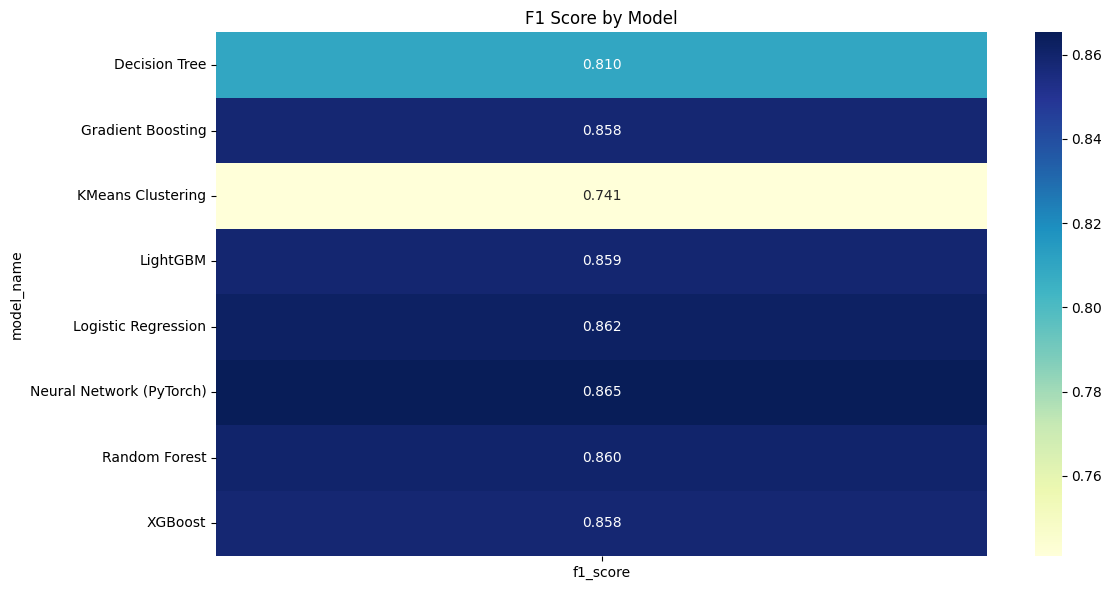

In [33]:
pivot_f1 = results_df.pivot_table(
    index='model_name', 
    values='f1_score'
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_f1, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("F1 Score by Model")
plt.tight_layout()
plt.show()

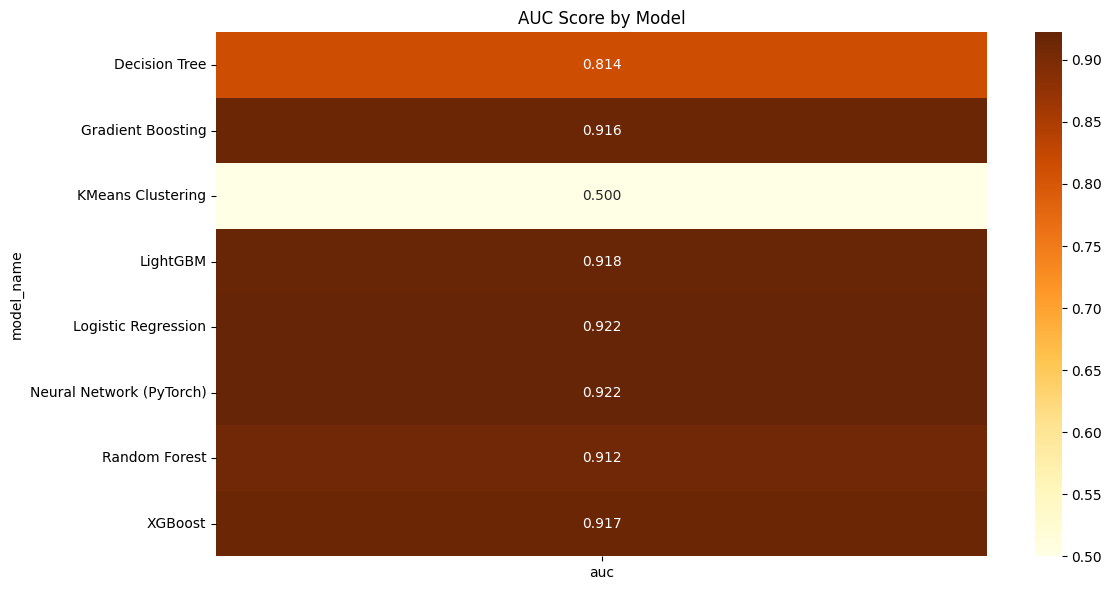

In [34]:
pivot_auc = results_df.pivot_table(
    index='model_name', 
    values='auc'
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_auc, annot=True, fmt=".3f", cmap="YlOrBr")
plt.title("AUC Score by Model")
plt.tight_layout()
plt.show()


## Cross Validation (Sklearn Models)
We now evaluate models using 5-fold Stratified Cross-Validation.


In [35]:
# Evaluate accuracy, F1, and AUC for each model using cross_validate
def evaluate_model_cv(model, X, y, name, scale=False):
    if scale:
        X = StandardScaler().fit_transform(X)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(model, X, y, scoring=['accuracy', 'f1', 'roc_auc'], cv=cv)
    return {
        'model_name': name,
        'accuracy': np.mean(scores['test_accuracy']),
        'f1_score': np.mean(scores['test_f1']),
        'auc': np.mean(scores['test_roc_auc']),
        'cv_std': np.std(scores['test_f1'])
    }

In [36]:
results_cv = []

for name, model in models.items():
    print(f"Running CV for: {name}")
    result = evaluate_model_cv(model, X, y, name)
    results_cv.append(result)

Running CV for: Logistic Regression
Running CV for: Decision Tree
Running CV for: Random Forest
Running CV for: XGBoost
Running CV for: Gradient Boosting
Running CV for: LightGBM


## PyTorch Neural Net + KMeans Clustering: Cross Validation
We train a new neural network per fold, and collect performance metrics, and label alignment is performed for each fold as well.

In [37]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# KMeans Clustering CV Evaluation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def align_clusters(y_true, y_pred):
    labels = np.zeros_like(y_pred)
    for i in np.unique(y_pred):
        mask = (y_pred == i)
        # Get scalar mode value only
        majority_label = mode(y_true[mask], keepdims=True).mode[0]
        labels[mask] = majority_label
    return labels

kmeans_metrics = {'accuracy': [], 'f1_score': [], 'auc': []}

for train_idx, test_idx in cv.split(X_scaled, y):
    X_train_fold, X_test_fold = X_scaled[train_idx], X_scaled[test_idx]
    y_train_fold, y_test_fold = y[train_idx], y[test_idx]

    kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
    kmeans.fit(X_train_fold)
    preds = kmeans.predict(X_test_fold)
    aligned_preds = align_clusters(y_test_fold, preds)

    kmeans_metrics['accuracy'].append(accuracy_score(y_test_fold, aligned_preds))
    kmeans_metrics['f1_score'].append(f1_score(y_test_fold, aligned_preds))
    kmeans_metrics['auc'].append(roc_auc_score(y_test_fold, aligned_preds))

print("\nKMeans Clustering Cross-Validation:")
print(f"Accuracy: {np.mean(kmeans_metrics['accuracy']):.4f}")
print(f"F1 Score: {np.mean(kmeans_metrics['f1_score']):.4f}")
print(f"AUC: {np.mean(kmeans_metrics['auc']):.4f}")

# Neural Network CV (PyTorch)

class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.out = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.sigmoid(self.out(x))
        return x

nn_metrics = {'accuracy': [], 'f1_score': [], 'auc': []}

for train_idx, test_idx in cv.split(X_scaled, y):
    # Prepare tensors
    X_train_fold = torch.tensor(X_scaled[train_idx], dtype=torch.float32)
    y_train_fold = torch.tensor(y.values[train_idx], dtype=torch.float32).view(-1, 1)
    X_test_fold = torch.tensor(X_scaled[test_idx], dtype=torch.float32)
    y_test_fold = torch.tensor(y.values[test_idx], dtype=torch.float32).view(-1, 1)

    # Dataloader for mini-batch training
    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Model
    model = AdvancedNet(input_dim=X.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # Training loop
    for epoch in range(30):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        probs = model(X_test_fold).numpy().flatten()
        preds = (probs >= 0.5).astype(int)
        y_true = y_test_fold.numpy().flatten()

        nn_metrics['accuracy'].append(accuracy_score(y_true, preds))
        nn_metrics['f1_score'].append(f1_score(y_true, preds))
        nn_metrics['auc'].append(roc_auc_score(y_true, probs))

# Final CV results
print("\nNeural Network (AdvancedNet) Cross-Validation:")
print(f"Accuracy: {np.mean(nn_metrics['accuracy']):.4f}")
print(f"F1 Score: {np.mean(nn_metrics['f1_score']):.4f}")
print(f"AUC: {np.mean(nn_metrics['auc']):.4f}")


KMeans Clustering Cross-Validation:
Accuracy: 0.6295
F1 Score: 0.7565
AUC: 0.5588

Neural Network (PyTorch) Cross-Validation:
Accuracy: 0.6716
F1 Score: 0.7798
AUC: 0.8256


## Cross-Validation Heatmaps
Heatmaps provide a quick overview of model performance across F1 and AUC.


In [39]:
traditional_df = pd.DataFrame(results_cv)

# KMeans results
kmeans_result = {
    'model_name': 'KMeans Clustering',
    'accuracy': np.mean(kmeans_metrics['accuracy']),
    'f1_score': np.mean(kmeans_metrics['f1_score']),
    'auc': np.mean(kmeans_metrics['auc']),
    'cv_std': np.std(kmeans_metrics['f1_score'])
}

# PyTorch NN results
nn_result = {
    'model_name': 'Neural Network (PyTorch)',
    'accuracy': np.mean(nn_metrics['accuracy']),
    'f1_score': np.mean(nn_metrics['f1_score']),
    'auc': np.mean(nn_metrics['auc']),
    'cv_std': np.std(nn_metrics['f1_score'])
}

# Combine all results
all_cv_results = pd.concat([traditional_df, pd.DataFrame([kmeans_result, nn_result])], ignore_index=True)

# Sort by F1 Score
all_cv_results = all_cv_results.sort_values(by='f1_score', ascending=False)

# Display table
print(all_cv_results[['model_name', 'accuracy', 'f1_score', 'auc', 'cv_std']]) 

                 model_name  accuracy  f1_score       auc    cv_std
0       Logistic Regression  0.845498  0.869698  0.926127  0.004323
3                   XGBoost  0.838322  0.864734  0.922078  0.003852
4         Gradient Boosting  0.837670  0.864323  0.920148  0.002627
5                  LightGBM  0.837017  0.863518  0.922177  0.002565
2             Random Forest  0.832719  0.863396  0.914502  0.002298
1             Decision Tree  0.772163  0.807256  0.819013  0.007173
7  Neural Network (PyTorch)  0.671580  0.779812  0.825629  0.010686
6         KMeans Clustering  0.629516  0.756477  0.558760  0.030967


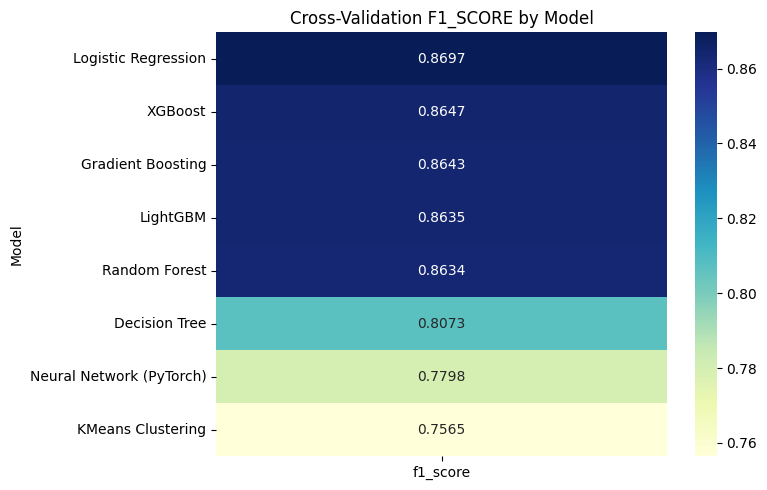

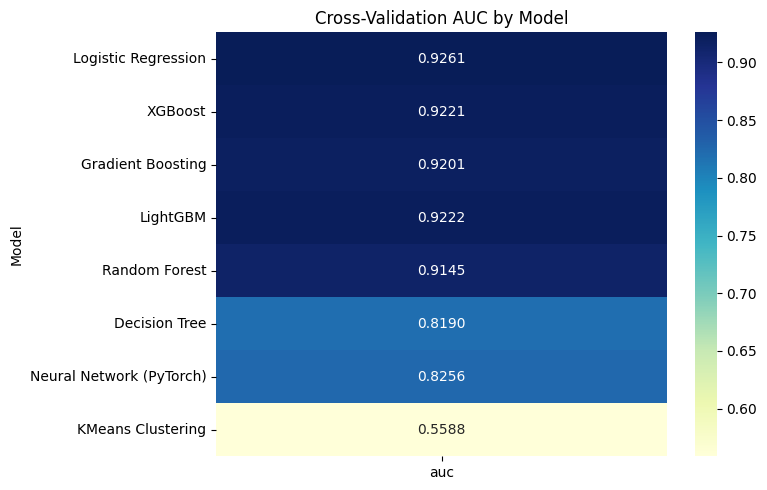

In [40]:
metrics_to_plot = ['f1_score', 'auc']

for metric in metrics_to_plot:
    pivot_df = all_cv_results[['model_name', metric]].set_index('model_name')
    
    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".4f", cbar=True)
    plt.title(f"Cross-Validation {metric.upper()} by Model")
    plt.ylabel("Model")
    plt.tight_layout()
    plt.show()

## HyperParameter Tuning
To push model performance, we perform GridSearchCV with cross-validation to find the best params for each model, with tuning being done with F1 as scoring.

In [41]:
param_grids = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1.0]
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 6],
            'verbose': [-1]
        }
    }
}

In [42]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tuned_results = []

for name, cfg in param_grids.items():
    print(f"\nRunning GridSearchCV for: {name}")
    grid = GridSearchCV(cfg['model'], cfg['params'], cv=cv, scoring='f1', n_jobs=-1)
    grid.fit(X, y)

    best_model = grid.best_estimator_
    scores = grid.cv_results_

    tuned_results.append({
        'model_name': name,
        'best_params': grid.best_params_,
        'mean_accuracy': np.mean(scores['mean_test_score']),
        'best_score': grid.best_score_
    })

tuned_df = pd.DataFrame(tuned_results)
tuned_df = tuned_df.sort_values(by='best_score', ascending=False)


Running GridSearchCV for: Logistic Regression

Running GridSearchCV for: Random Forest

Running GridSearchCV for: Gradient Boosting

Running GridSearchCV for: XGBoost

Running GridSearchCV for: LightGBM


In [43]:
print(tuned_df[['model_name', 'best_params', 'best_score']])

            model_name                                        best_params  \
0  Logistic Regression    {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}   
2    Gradient Boosting  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
3              XGBoost  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
4             LightGBM  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
1        Random Forest  {'max_depth': 20, 'min_samples_split': 2, 'n_e...   

   best_score  
0    0.869879  
2    0.866348  
3    0.866246  
4    0.865993  
1    0.864135  


In [46]:
final_tuned_cv_results = []

for _, row in tuned_df.iterrows():
    model_name = row['model_name']
    params = row['best_params']

    if model_name == 'Logistic Regression':
        model = LogisticRegression(**params, max_iter=1000)
    elif model_name == 'Gradient Boosting':
        model = GradientBoostingClassifier(**params)
    elif model_name == 'XGBoost':
        model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
    elif model_name == 'LightGBM':
        model = LGBMClassifier(**params)
    elif model_name == 'Random Forest':
        model = RandomForestClassifier(**params)
    else:
        continue  # Skip unsupported models

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(model, X, y, cv=cv,
                            scoring=['accuracy', 'f1', 'roc_auc'])

    final_tuned_cv_results.append({
        'model_name': model_name,
        'accuracy': np.mean(scores['test_accuracy']),
        'f1_score': np.mean(scores['test_f1']),
        'auc': np.mean(scores['test_roc_auc']),
        'cv_std': np.std(scores['test_f1']),
        'best_params': params
    })

In [51]:
final_cv_df = pd.DataFrame(final_tuned_cv_results).sort_values(by='f1_score', ascending=False)
final_cv_df = pd.concat([
    pd.DataFrame(final_tuned_cv_results),
    pd.DataFrame([
        {
            "model_name": "Neural Network (PyTorch)",
            "accuracy": 0.671580,  
            "f1_score": 0.779812,
            "auc": 0.825629,
            "cv_std": 0.010686,
            "best_params": "AdvancedNet (custom)"
        },
        {
            "model_name": "KMeans Clustering",
            "accuracy": 0.629516,
            "f1_score": 0.756477,
            "auc": 0.558760,
            "cv_std": 0.030967,
            "best_params": "n_clusters=2"
        },
        {
            "model_name": "Decision Tree",
            "accuracy": 0.772163,
            "f1_score": 0.807256,
            "auc": 0.819013,
            "cv_std": 0.007173,
            "best_params": "n/a"
        }
    ])
], ignore_index=True)

## Summary of Tuned Results
This section displays the best hyperparameters and model scores after tuning.

In [52]:
print(final_cv_df[['model_name', 'accuracy', 'f1_score', 'auc', 'cv_std', 'best_params']])

                 model_name  accuracy  f1_score       auc    cv_std  \
0       Logistic Regression  0.845575  0.869879  0.926113  0.004439   
1         Gradient Boosting  0.840893  0.866560  0.921828  0.004334   
2                   XGBoost  0.841277  0.866802  0.923068  0.004228   
3                  LightGBM  0.840126  0.865993  0.922344  0.004411   
4             Random Forest  0.834753  0.864783  0.914553  0.001822   
5  Neural Network (PyTorch)  0.671580  0.779812  0.825629  0.010686   
6         KMeans Clustering  0.629516  0.756477  0.558760  0.030967   
7             Decision Tree  0.772163  0.807256  0.819013  0.007173   

                                         best_params  
0    {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}  
1  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  
2  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  
3  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  
4  {'max_depth': 20, 'min_samples_split': 2, 'n_e...  
5                             

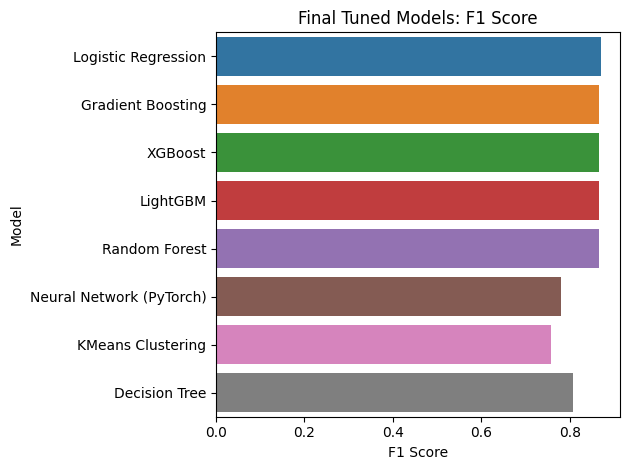

In [53]:
sns.barplot(data=final_cv_df, x='f1_score', y='model_name')
plt.title('Final Tuned Models: F1 Score')
plt.xlabel('F1 Score')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

In [54]:
final_cv_df.to_csv("results/final_cv_PCA_Transformed.csv", index=False)

## Final Summary & Key Takeaways (`pca_transformed` Feature Set)

In this notebook, we evaluated a diverse suite of models using the `pca_transformed` feature set — a dimensionality-reduced version of the original data, derived using **Principal Component Analysis (PCA)**. This unsupervised technique projects the data onto directions of **maximum variance**, without considering the target label. PCA is useful for reducing overfitting, improving computational efficiency, and handling multicollinearity.

### Models Implemented:
- **Traditional Machine Learning**:  
  - Logistic Regression  
  - Random Forest  
  - Decision Tree  
  - Gradient Boosting  
  - LightGBM  
  - XGBoost

- **Unsupervised Learning**:  
  - KMeans Clustering (aligned using majority voting)

- **Deep Learning**:  
  - PyTorch Neural Network (AdvancedNet with batch normalization, dropout, and learning rate scheduler)

---

### Evaluation Process:
1. **Consistent training** across all models using the same `pca_transformed` components (top 31).
2. **Stratified 5-Fold Cross-Validation** for performance evaluation.
3. **Hyperparameter tuning** for all supervised ML models using `GridSearchCV`.
4. **Performance Aggregation** across metrics: **F1 Score**, **AUC**, **Accuracy**, and **CV Std**.

---

### Key Insights:

- **Logistic Regression was the top-performing model**, with the highest **F1 Score (0.8698)** and **AUC (0.9261)**. This shows that:
  - The PCA components still **preserve linear signal** in the data.
  - Even after transformation, LR can extract meaningful separation in component space.

- **Gradient Boosting, XGBoost, and LightGBM** followed closely with strong scores across all metrics.  
  These models benefit from their ability to **handle mixed signal and weak interactions** between PCA-derived components.

- **The PyTorch Neural Network (AdvancedNet)** saw its **worst performance yet (F1 = 0.7798, Accuracy = 67%)**, indicating:
  - PCA significantly **degrades the feature space** needed for a deep network to learn.
  - The transformation likely removed nonlinear structure or relevant spatial alignment.
  - Neural nets require **expressive raw or engineered features** — not compressed components.

- **KMeans Clustering**, despite some improvement, still lags significantly behind, reaffirming that **unsupervised methods struggle in reduced feature spaces** without task-specific supervision.

---

### Final Thoughts:

While PCA reduced dimensionality and may help prevent overfitting in theory, in practice, it **compromised performance** for models relying on raw feature semantics — especially deep learning.

---

### Next Steps:

- **Conclude the modeling pipeline**, and move to a **final comparative analysis notebook** across all three feature sets:
  - `mutual_info_filtered`
  - `anova_top_30`
  - `pca_transformed`

- Explore:
  - Which models benefit most from compact, unsupervised features.
  - How interpretable vs. compressed features affect overall generalization.
  - Final model selection considering tradeoffs: **performance**, **complexity**, and **interpretability**.

In this notebook, **Logistic Regression is the best-performing model**, even after unsupervised transformation — proving its robustness and consistency across diverse feature engineering pipelines.
